In [1]:
import pandas as pd
import numpy as np
np.random.seed(1234)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [2]:
df = pd.read_csv("./bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.shape

(4857377, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


Text(0.5, 1.0, 'Feature Correlation Plot')

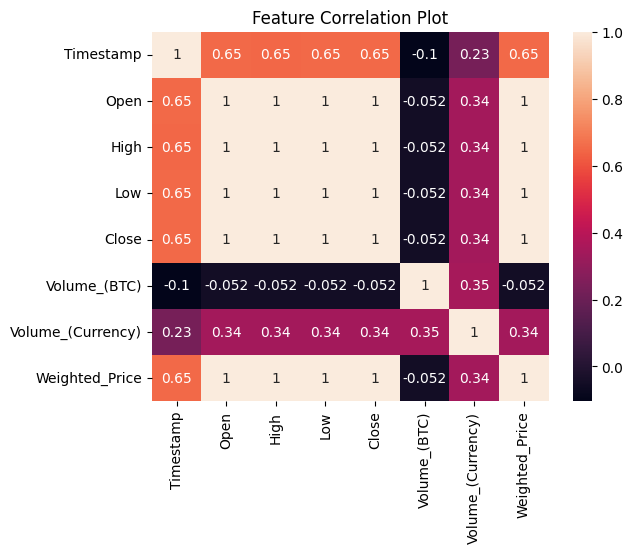

In [5]:
sns.heatmap(df.corr(), annot=True)
plt.title("Feature Correlation Plot")

Text(0.5, 1.0, 'BitCoin Price Dynamics')

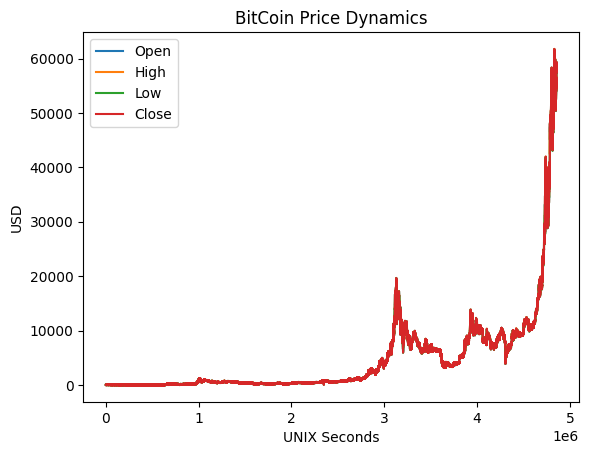

In [6]:
ax = df["Open"].plot(legend=True)
df["High"].plot(axes=ax, legend=True)
df["Low"].plot(axes=ax, legend=True)
df["Close"].plot(axes=ax, legend=True)
ax.set_ylabel("USD")
ax.set_xlabel("UNIX Seconds")
ax.set_title("BitCoin Price Dynamics")

In [7]:
num = 50
start = int(1e6)
finish = start+num

Text(0.5, 1.0, 'BitCoin Price Dynamics')

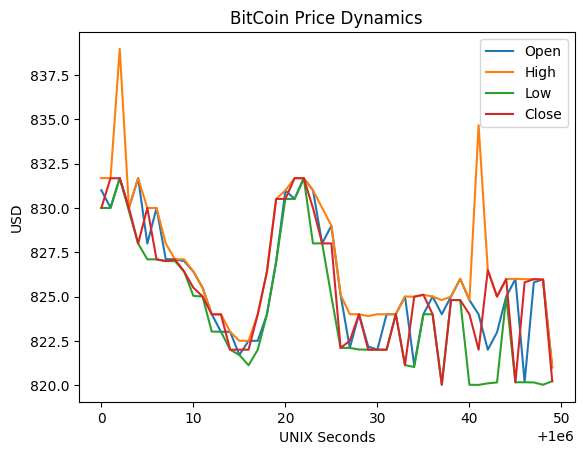

In [8]:
ax = df["Open"][start:finish].plot(legend=True)
df["High"][start:finish].plot(axes=ax, legend=True)
df["Low"][start:finish].plot(axes=ax, legend=True)
df["Close"][start:finish].plot(axes=ax, legend=True)
ax.set_ylabel("USD")
ax.set_xlabel("UNIX Seconds")
ax.set_title("BitCoin Price Dynamics")

Text(0.5, 1.0, 'BitCoin Price Fractional Change Dynamics')

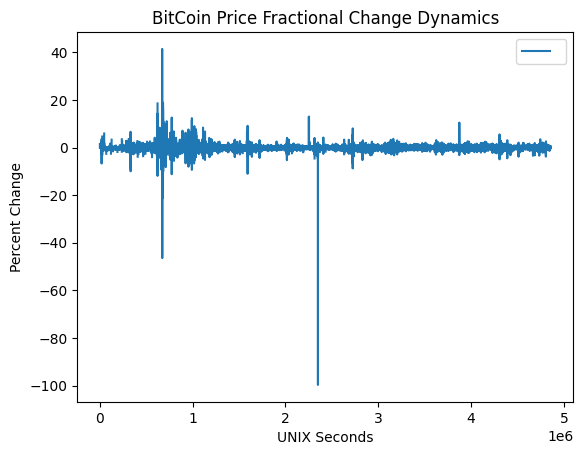

In [9]:
ax = (100*(df["Close"] - df["Open"])/df["Open"]).plot(legend=True)
ax.set_ylabel("Percent Change")
ax.set_xlabel("UNIX Seconds")
ax.set_title("BitCoin Price Fractional Change Dynamics")

BELOW FOR HMMs

In [10]:
import numpy as np
from hmmlearn import hmm
np.random.seed(42)

model = hmm.GaussianHMM(n_components=3, covariance_type="full")
model.startprob_ = np.array([0.6, 0.3, 0.1])
model.transmat_ = np.array([[0.2, 0.7, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])
model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
model.covars_ = np.tile(np.identity(2), (3, 1, 1))
X, Z = model.sample(20)

In [11]:

# First, we will remove outlier rows where fractional open to close price exceeds 20% as this only appears to 
# occur three times in the 10 years of minute-date
df_reduced = df.drop(df[((df['Close']-df['Open'])/df['Open']).abs() > 0.2].index)

# The following will remove all time windows in which trading did not occur. 
# In order to note forget these windows, 'Timestamp' is replaced by 'TimeDelta' 
# which represents time since last trade. We posit that this is a valid observed variable.
df_reduced.dropna(inplace=True)
df_reduced['TimeDelta'] = df_reduced['Timestamp'].diff()
df_reduced['TimeDelta'][0] = 60.0

# Using limited portion of newer data
training_and_display_index = -500000
df_reduced = df_reduced[training_and_display_index:]
df_reduced.reset_index(drop=True, inplace=True)

# Display DataFrame
df_reduced

/tmp/ipykernel_11931/1754176908.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['TimeDelta'][0] = 60.0


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,TimeDelta
0,1586723220,7157.99,7175.89,7157.99,7175.89,2.626955,18834.182742,7169.586195,60.0
1,1586723280,7171.45,7171.47,7166.66,7166.66,2.311462,16576.539263,7171.452921,60.0
2,1586723340,7171.94,7180.00,7166.69,7172.34,120.154712,862425.892290,7177.628554,60.0
3,1586723400,7178.67,7178.67,7171.94,7171.94,1.668730,11968.323129,7172.113810,60.0
4,1586723460,7173.62,7176.85,7171.94,7174.79,8.732161,62634.762287,7172.882012,60.0
...,...,...,...,...,...,...,...,...,...
499995,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,60.0
499996,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,60.0
499997,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,60.0
499998,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,60.0


Text(0.5, 1.0, 'BitCoin Price Fractional Change Dynamics - Reduced Data')

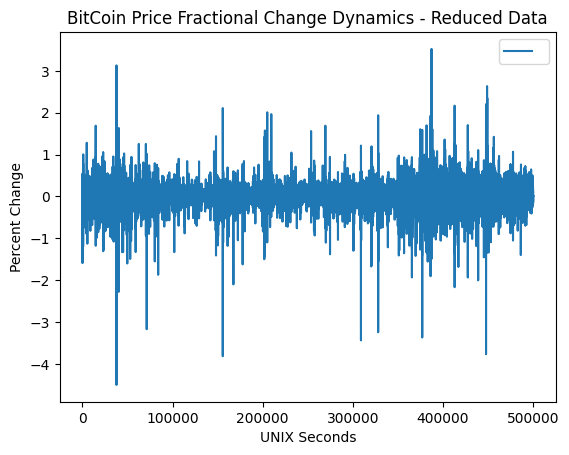

In [12]:
ax = (100*(df_reduced["Close"] - df_reduced["Open"])/df_reduced["Open"])[training_and_display_index:].plot(legend=True)
ax.set_ylabel("Percent Change")
ax.set_xlabel("UNIX Seconds")
ax.set_title("BitCoin Price Fractional Change Dynamics - Reduced Data")

Average Fractional Change: 0.0665456664797448%
0.001


Text(0, 0.5, 'Number of Occurances')

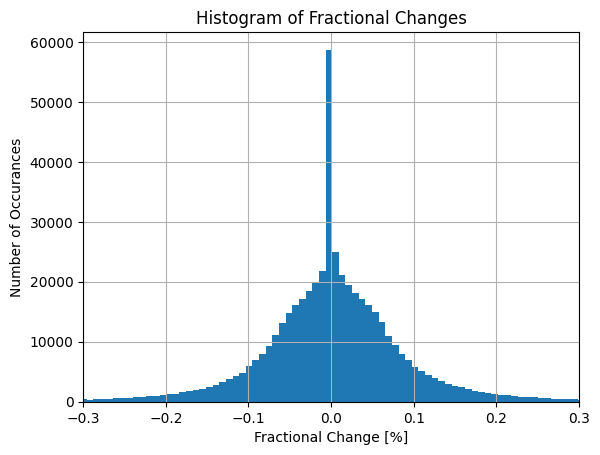

In [13]:
a = (100*(df_reduced["Close"] - df_reduced["Open"])/df_reduced["Open"])
print(f"Average Fractional Change: {np.mean(np.abs(a))}%")
print(1e-3)
ax = a.hist(bins=1000)
ax.set_xlim(-0.3,0.3)
ax.set_title("Histogram of Fractional Changes")
ax.set_xlabel("Fractional Change [%]")
ax.set_ylabel("Number of Occurances")

Text(0.5, 1.0, 'BTC Prices - ~ Final Year - Reduced Data')

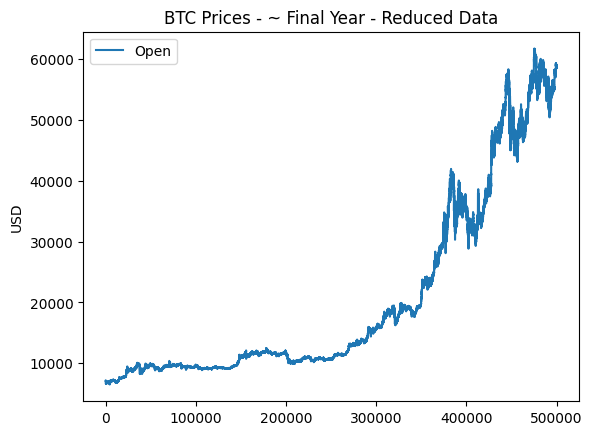

In [14]:
ax = df_reduced["Open"].plot(legend=True)
# df_reduced["High"][-500000:].plot(axes=ax, legend=True)
# df_reduced["Low"][-500000:].plot(axes=ax, legend=True)
# df_reduced["Close"][-500000:].plot(axes=ax, legend=True)
ax.set_ylabel("USD")
ax.set_title("BTC Prices - ~ Final Year - Reduced Data")

In [15]:
df_reduced['FracHigh'] = (df_reduced['High']-df_reduced['Open'])/df_reduced['Open']
df_reduced['FracLow'] = (df_reduced['Open']-df_reduced['Low'])/df_reduced['Open']
df_reduced['FracChange'] = (df_reduced['Close']-df_reduced['Open'])/df_reduced['Open']
df_reduced.drop(columns=["Timestamp", "Open", "High", "Low", "Close", "Volume_(BTC)", "Weighted_Price"], inplace=True)
df_reduced.shape

(500000, 5)

In [16]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Volume_(Currency)  500000 non-null  float64
 1   TimeDelta          500000 non-null  float64
 2   FracHigh           500000 non-null  float64
 3   FracLow            500000 non-null  float64
 4   FracChange         500000 non-null  float64
dtypes: float64(5)
memory usage: 19.1 MB


BELOW FOR REGRESSIONS

The implementations below are from https://github.com/ctgk/PRML
 
Polynomial Feature

In [17]:
import itertools
import functools
import numpy as np

class PolynomialFeature(object):
    """
    polynomial features

    transforms input array with polynomial features

    Example
    =======
    x =
    [[a, b],
    [c, d]]

    y = PolynomialFeatures(degree=2).transform(x)
    y =
    [[1, a, b, a^2, a * b, b^2],
    [1, c, d, c^2, c * d, d^2]]
    """

    def __init__(self, degree=1):
        """
        construct polynomial features

        Parameters
        ----------
        degree : int
            degree of polynomial
        """
        assert isinstance(degree, int)
        self.degree = degree

    def transform(self, x):
        """
        transforms input array with polynomial features

        Parameters
        ----------
        x : (sample_size, n) ndarray
            input array

        Returns
        -------
        output : (sample_size, 1 + nC1 + ... + nCd) ndarray
            polynomial features
        """
        if x.ndim == 1:
            x = x[:, None]
        x_t = x.transpose()
        features = [np.ones(len(x))]
        for degree in range(1, self.degree + 1):
            for items in itertools.combinations_with_replacement(x_t, degree):
                features.append(functools.reduce(lambda x, y: x * y, items))
        return np.asarray(features).transpose()

Models for standard linear regression, Bayesian regression, and empirical Bayesian regression

In [18]:
import numpy as np

class LinearRegression():
    """
    Linear regression model
    y = X @ w
    t ~ N(t|X @ w, var)
    """

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        perform least squares fitting

        Parameters
        ----------
        X : (N, D) np.ndarray
            training independent variable
        t : (N,) np.ndarray
            training dependent variable
        """
        self.w = np.linalg.pinv(X) @ t
        self.var = np.mean(np.square(X @ self.w - t))

    def predict(self, X:np.ndarray, return_std:bool=False):
        """
        make prediction given input

        Parameters
        ----------
        X : (N, D) np.ndarray
            samples to predict their output
        return_std : bool, optional
            returns standard deviation of each prediction if True

        Returns
        -------
        y : (N,) np.ndarray
            prediction of each sample
        y_std : (N,) np.ndarray
            standard deviation of each prediction
        """
        y = X @ self.w
        if return_std:
            y_std = np.sqrt(self.var) + np.zeros_like(y)
            return y, y_std
        return y

In [19]:
class BayesianRegression():
    """
    Bayesian regression model

    w ~ N(w|0, alpha^(-1)I)
    y = X @ w
    t ~ N(t|X @ w, beta^(-1))
    """

    def __init__(self, alpha:float=1., beta:float=1.):
        self.alpha = alpha
        self.beta = beta
        self.w_mean = None
        self.w_precision = None

    def _is_prior_defined(self) -> bool:
        return self.w_mean is not None and self.w_precision is not None

    def _get_prior(self, ndim:int) -> tuple:
        if self._is_prior_defined():
            return self.w_mean, self.w_precision
        else:
            return np.zeros(ndim), self.alpha * np.eye(ndim)

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        bayesian update of parameters given training dataset

        Parameters
        ----------
        X : (N, n_features) np.ndarray
            training data independent variable
        t : (N,) np.ndarray
            training data dependent variable
        """

        mean_prev, precision_prev = self._get_prior(np.size(X, 1))

        w_precision = precision_prev + self.beta * X.T @ X
        w_mean = np.linalg.solve(
            w_precision,
            precision_prev @ mean_prev + self.beta * X.T @ t
        )
        self.w_mean = w_mean
        self.w_precision = w_precision
        self.w_cov = np.linalg.inv(self.w_precision)

    def predict(self, X:np.ndarray, return_std:bool=False, sample_size:int=None):
        """
        return mean (and standard deviation) of predictive distribution

        Parameters
        ----------
        X : (N, n_features) np.ndarray
            independent variable
        return_std : bool, optional
            flag to return standard deviation (the default is False)
        sample_size : int, optional
            number of samples to draw from the predictive distribution
            (the default is None, no sampling from the distribution)

        Returns
        -------
        y : (N,) np.ndarray
            mean of the predictive distribution
        y_std : (N,) np.ndarray
            standard deviation of the predictive distribution
        y_sample : (N, sample_size) np.ndarray
            samples from the predictive distribution
        """

        if sample_size is not None:
            w_sample = np.random.multivariate_normal(
                self.w_mean, self.w_cov, size=sample_size
            )
            y_sample = X @ w_sample.T
            return y_sample
        y = X @ self.w_mean
        if return_std:
            y_var = 1 / self.beta + np.sum(X @ self.w_cov * X, axis=1)
            y_std = np.sqrt(y_var)
            return y, y_std
        return y



    def _log_likelihood(self, X, t, w):
        return -0.5 * self.beta * np.square(t - X @ w).sum()

In [20]:
class EmpiricalBayesRegression(BayesianRegression):
    """
    Empirical Bayes Regression model
    a.k.a.
    type 2 maximum likelihood,
    generalized maximum likelihood,
    evidence approximation

    w ~ N(w|0, alpha^(-1)I)
    y = X @ w
    t ~ N(t|X @ w, beta^(-1))
    evidence function p(t|X,alpha,beta) = S p(t|w;X,beta)p(w|0;alpha) dw
    """

    def __init__(self, alpha:float=1., beta:float=1.):
        super().__init__(alpha, beta)

    def fit(self, X:np.ndarray, t:np.ndarray, max_iter:int=100):
        """
        maximization of evidence function with respect to
        the hyperparameters alpha and beta given training dataset

        Parameters
        ----------
        X : (N, D) np.ndarray
            training independent variable
        t : (N,) np.ndarray
            training dependent variable
        max_iter : int
            maximum number of iteration
        """
        M = X.T @ X
        eigenvalues = np.linalg.eigvalsh(M)
        eye = np.eye(np.size(X, 1))
        N = len(t)
        for it in range(max_iter):
            params = [self.alpha, self.beta]
            if not(it):
                alpha_ = [self.alpha]
                beta_ = [self.beta]
            else:
                alpha_ = np.hstack((alpha_, self.alpha))
                beta_ = np.hstack((beta_, self.beta))
            w_precision = self.alpha * eye + self.beta * X.T @ X
            w_mean = self.beta * np.linalg.solve(w_precision, X.T @ t) 

            gamma = np.sum(eigenvalues / (self.alpha + eigenvalues))
            self.alpha = float(gamma / np.sum(w_mean ** 2).clip(min=1e-10))
            self.beta = float(
                (N - gamma) / np.sum(np.square(t - X @ w_mean))
            )
            if np.allclose(params, [self.alpha, self.beta]):
                break
        self.w_mean = w_mean
        self.w_precision = w_precision
        self.w_cov = np.linalg.inv(w_precision)
        self.alpha_ = alpha_
        self.beta_ = beta_

    def _log_prior(self, w):
        return -0.5 * self.alpha * np.sum(w ** 2)

    def _log_likelihood(self, X, t, w):
        return -0.5 * self.beta * np.square(t - X @ w).sum()

    def _log_posterior(self, X, t, w):
        return self._log_likelihood(X, t, w) + self._log_prior(w)

    def log_evidence(self, X:np.ndarray, t:np.ndarray):
        """
        logarithm or the evidence function

        Parameters
        ----------
        X : (N, D) np.ndarray
            indenpendent variable
        t : (N,) np.ndarray
            dependent variable
        Returns
        -------
        float
            log evidence
        """
        N = len(t)
        D = np.size(X, 1)
        return 0.5 * (
            D * np.log(self.alpha) + N * np.log(self.beta)
            - np.linalg.slogdet(self.w_precision)[1] - D * np.log(2 * np.pi)
        ) + self._log_posterior(X, t, self.w_mean)

In [21]:
class EM(BayesianRegression):
    """
    Expectation Maximization (EM)

    w ~ N(w|0, alpha^(-1)I)
    y = X @ w
    t ~ N(t|X @ w, beta^(-1))
    """

    def __init__(self, alpha:float=1., beta:float=1.):
        super().__init__(alpha, beta)

    def fit(self, X:np.ndarray, t:np.ndarray, max_iter:int=1000):
        """
        maximization of evidence function with respect to
        the hyperparameters alpha and beta given training dataset

        Parameters
        ----------
        X : (N, D) np.ndarray
            training independent variable
        t : (N,) np.ndarray
            training dependent variable
        max_iter : int
            maximum number of iteration
        """
        K=np.size(X, 1)
        eye = np.eye(K)
        N = len(t)
        for it in range(max_iter):
            params = [self.alpha, self.beta]
            if not(it):
                alpha_ = [self.alpha]
                beta_ = [self.beta]
            else:
                alpha_ = np.hstack((alpha_, self.alpha))
                beta_ = np.hstack((beta_, self.beta))
            w_precision = self.alpha * eye + self.beta * X.T @ X
            w_mean = self.beta * np.linalg.solve(w_precision, X.T @ t)            
            self.alpha = float(K / (np.trace(np.linalg.inv(w_precision))
                                    +np.sum(w_mean ** 2)))
            self.beta = float(
                N / (np.sum(np.square(t - X @ w_mean))
                     +np.trace(X @ np.linalg.inv(w_precision) @ X.T))
            )
            if np.allclose(params, [self.alpha, self.beta]):
                break
        self.w_mean = w_mean
        self.w_precision = w_precision
        self.w_cov = np.linalg.inv(w_precision)
        self.alpha_ = alpha_
        self.beta_ = beta_

    def _log_prior(self, w):
        return -0.5 * self.alpha * np.sum(w ** 2)

    def _log_likelihood(self, X, t, w):
        return -0.5 * self.beta * np.square(t - X @ w).sum()

    def _log_posterior(self, X, t, w):
        return self._log_likelihood(X, t, w) + self._log_prior(w)

    def log_evidence(self, X:np.ndarray, t:np.ndarray):
        """
        logarithm or the evidence function

        Parameters
        ----------
        X : (N, D) np.ndarray
            indenpendent variable
        t : (N,) np.ndarray
            dependent variable
        Returns
        -------
        float
            log evidence
        """
        N = len(t)
        D = np.size(X, 1)
        return 0.5 * (
            D * np.log(self.alpha) + N * np.log(self.beta)
            - np.linalg.slogdet(self.w_precision)[1] - D * np.log(2 * np.pi)
        ) + self._log_posterior(X, t, self.w_mean)

In [22]:
class VB(BayesianRegression):
    """
    Variational Bayes (VB)

    w ~ N(w|0, alpha^(-1)I)
    y = X @ w
    t ~ N(t|X @ w, beta^(-1))
    """

    def __init__(self, alpha:float=1., beta:float=1.):
        super().__init__(alpha, beta)

    def fit(self, X:np.ndarray, t:np.ndarray, max_iter:int=10000):
        """
        maximization of evidence function with respect to
        the hyperparameters alpha and beta given training dataset

        Parameters
        ----------
        X : (N, D) np.ndarray
            training independent variable
        t : (N,) np.ndarray
            training dependent variable
        max_iter : int
            maximum number of iteration
        """
        a,b,c,d = 1e-6,1e-6,1e-6,1e-6
        K=np.size(X, 1)
        N = len(t)
        self.alpha = self.alpha * np.ones(K)
        for it in range(max_iter):
            params = [np.mean(self.alpha), self.beta]
            if not(it):
                alpha_ = [self.alpha]
                beta_ = [self.beta]
            else:
                alpha_ = np.vstack((alpha_, self.alpha))
                beta_ = np.hstack((beta_, self.beta))
            w_precision = np.diag(self.alpha) + self.beta * X.T @ X
            w_mean = self.beta * np.linalg.solve(w_precision, X.T @ t)   
            
            at = a + 0.5
            bt = b + 0.5 * (np.diag(np.linalg.inv(w_precision)) + w_mean ** 2)
            self.alpha = at/bt
            
            ct = c + N/2
            dt = d + 0.5 * (np.sum(np.square(t - X @ w_mean))
                     +np.trace(X @ np.linalg.inv(w_precision) @ X.T))
            self.beta = ct/dt
            
            if np.allclose(params, [np.mean(self.alpha),self.beta]):
                break
        self.w_mean = w_mean
        self.w_precision = w_precision
        self.w_cov = np.linalg.inv(w_precision)
        self.alpha_ = alpha_
        self.beta_ = beta_ 
                
    def _log_prior(self, w):
        return -0.5 * self.alpha * np.sum(w ** 2)

    def _log_likelihood(self, X, t, w):
        return -0.5 * self.beta * np.square(t - X @ w).sum()

    def _log_posterior(self, X, t, w):
        return self._log_likelihood(X, t, w) + self._log_prior(w)

    def log_evidence(self, X:np.ndarray, t:np.ndarray):
        """
        logarithm or the evidence function

        Parameters
        ----------
        X : (N, D) np.ndarray
            indenpendent variable
        t : (N,) np.ndarray
            dependent variable
        Returns
        -------
        float
            log evidence
        """
        N = len(t)
        D = np.size(X, 1)
        return 0.5 * (
            D * np.log(self.alpha) + N * np.log(self.beta)
            - np.linalg.slogdet(self.w_precision)[1] - D * np.log(2 * np.pi)
        ) + self._log_posterior(X, t, self.w_mean)

In [23]:
 np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

In [24]:
btc_data = df_reduced.to_numpy()
print(btc_data[0:5])
# ###
# THIS PARAMETER IS IMPORTANT 
# It determines how many previous trade windows make up the feature vector for the current trade window
num_windows = 2
# ###
final_column_num = (num_windows+1)*btc_data.shape[1]-1
print(f"Final Column Number: {final_column_num}")
btc_features = []
for idx in range(btc_data.shape[0]):
    if idx in range(num_windows): continue
    single_feat_vec = []
    for i in range(num_windows+1):
        single_feat_vec.append(btc_data[idx-num_windows+i])
    btc_features.append(np.array(single_feat_vec).flatten())
btc_features = np.array(btc_features)
print(btc_features.shape)

[[18834.18 60.00 0.00 0.00 0.00]
 [16576.54 60.00 0.00 0.00 -0.00]
 [862425.89 60.00 0.00 0.00 0.00]
 [11968.32 60.00 0.00 0.00 -0.00]
 [62634.76 60.00 0.00 0.00 0.00]]
Final Column Number: 14
(499998, 15)


In [25]:
# #Scatter plot of the data
# from pandas.plotting import scatter_matrix

# scatter_matrix(df_btc_features,figsize = (12,12))
# print('The correlation matrix:')
# corr_mtx = df_btc_features.corr()
# corr_mtx.round(2)

In [26]:
# corr_mtx['MedValue'].abs().sort_values(ascending = False)

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## convert the dataframe to numpy array
X,y = btc_features[:,:final_column_num-btc_data.shape[1]+1], btc_features[:,-1]

## We can also directly import X,y from sklearn (without using pandas package)
# X,y = load_boston(return_X_y=True)


## Spliting training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X.shape,y.shape,X_train.shape, y_train.shape, X_test.shape, y_test.shape )
# print(f"{(X_train[0:2])}")
# print(y_train[0:5])

(499998, 10) (499998,) (399998, 10) (399998,) (100000, 10) (100000,)


In [28]:
from sklearn.preprocessing import StandardScaler
# standarization
std_trans = StandardScaler()
X_train = std_trans.fit_transform(X_train)
X_test = std_trans.transform(X_test)
# print(f"{(X_train[0:2])}")

## Linear Regression and Bayesian Regressian

In [29]:
feature = PolynomialFeature(degree=1)
X_train1, X_test1 = feature.transform(X_train), feature.transform(X_test)

In [30]:
# Linear Regression
Linear = LinearRegression()
Linear.fit(X_train1, y_train)
y_pred_lin = Linear.predict(X_test1)
errors_linear = mean_squared_error(y_pred_lin,y_test)
print(f"MSE - Linear: {errors_linear}")

MSE - Linear: 1.227435573850567e-06


In [31]:
# Bayes Regression
Bayes = BayesianRegression(alpha=1., beta=100.)
errors_bayes = []
Bayes.fit(X_train1, y_train)
y_pred_bayes = Bayes.predict(X_test1)
errors_bayes = mean_squared_error(y_pred_bayes,y_test)
print(f"MSE - Bayes: {errors_bayes}")

MSE - Bayes: 1.2274355733333709e-06


In [32]:
# Support Vector Regression
from sklearn.svm import SVR
# regr = svm.SVR(kernel='sigmoid')
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)
best_SVR, best_MSE, best_y_pred_SVR = None, None, None
for model in [svr_rbf, svr_lin, svr_poly]:
    model.fit(X_train1, y_train)
    y_pred_SVR = model.predict(X_test1)
    errors_SVR = mean_squared_error(y_pred_SVR,y_test)
    if best_MSE == None or errors_SVR < best_MSE:
        best_SVR = model
        best_MSE = errors_SVR
        best_y_pred_SVR = y_pred_SVR
print(f"MSE - SVR: {best_MSE} with kernel {best_SVR.kernel}")

MSE - SVR: 2.5214021895824034e-05 with kernel rbf


## Decision Trees

In [33]:
# Decision Tree Regression
from sklearn import tree
num = -1000
DT = tree.DecisionTreeRegressor()
DT = DT.fit(X_train1[num:], y_train[num:])
y_pred_DT = DT.predict(X_test1[num:])
errors_DT = mean_squared_error(y_pred_DT,y_test[num:])
print(f"MSE - Decision Tree: {errors_DT}")

MSE - Decision Tree: 2.4027840594267907e-06


In [34]:
num = -50000
from sklearn.ensemble import ExtraTreesRegressor
ETR = ExtraTreesRegressor(n_estimators=10, random_state=42)
ETR = ETR.fit(X_train1[num:], y_train[num:])
y_pred_ETR = ETR.predict(X_test1[num:])
errors_ETR = mean_squared_error(y_pred_ETR,y_test[num:])
print(f"MSE - Extra Random Decision Trees: {errors_ETR}")

MSE - Extra Random Decision Trees: 1.4586935340019697e-06


## Neural Networks

In [35]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [36]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train1)
print(normalizer.mean.numpy())

2023-03-24 22:07:37.165694: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-24 22:07:37.274018: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-24 22:07:37.274725: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 22:07:37.924760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0


2023-03-24 22:07:38.717262: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17599912 exceeds 10% of free system memory.


[[1.00 0.00 -0.00 -0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]]


In [37]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [38]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [39]:
%%time
history = linear_model.fit(
    X_train1,
    y_train,
    epochs=4,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 19.3 s, sys: 1.03 s, total: 20.3 s
Wall time: 16 s


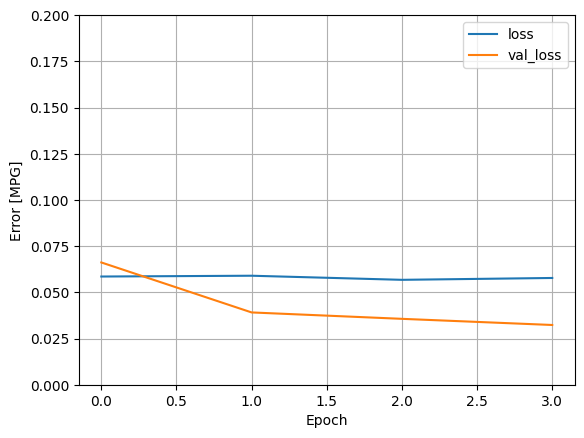

In [40]:
plot_loss(history)

In [41]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [42]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 11)               23        
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                768       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,016
Trainable params: 4,993
Non-trainable params: 23
_________________________________________________________________


In [43]:
%%time
history = dnn_model.fit(
    X_train1,
    y_train,
    validation_split=0.2,
    verbose=1, epochs=2)

Epoch 1/2
10000/10000 [==============================] - 6s 561us/step - loss: 0.0030 - val_loss: 6.7642e-04
Epoch 2/2
10000/10000 [==============================] - 6s 557us/step - loss: 6.9818e-04 - val_loss: 6.7228e-04
CPU times: user 15.5 s, sys: 721 ms, total: 16.2 s
Wall time: 11.5 s


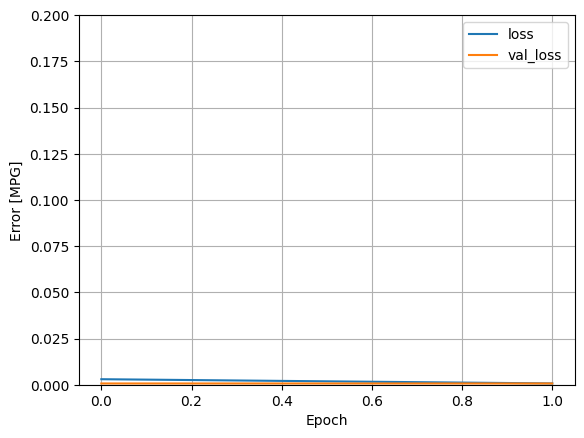

In [44]:
plot_loss(history)

In [45]:
y_pred_dnn = dnn_model.predict(X_test1).flatten()

3125/3125 [==============================] - 1s 338us/step


## Empirical Bayes Approach

In [46]:
empirical_Bayes = EmpiricalBayesRegression(alpha=1., beta=100.)
empirical_Bayes.fit(X_train1, y_train)
y_pred_emp_bayes = empirical_Bayes.predict(X_test1)
errors_empirical = mean_squared_error(y_pred_emp_bayes,y_test)
# plt.plot([errors_empirical]*X_train1.shape[0], 'y-.', label = 'Empirical Regression')
# plt.plot(errors_bayes,  'r', label = 'Bayesian Regression' ,linewidth = 2.)
# plt.plot([errors_linear]*X_train1.shape[0], 'b:', label = 'Linear Regression')

# plt.yscale('log')
# plt.xlabel('Iterations')
# plt.ylabel('Validation MSE')
# plt.legend()

## Expectation Maximization Algorithm

In [47]:
np.random.seed(51)
num = -5000
mEM = EM(alpha=1., beta=1.)
mEM.fit(X_train1[num:], y_train[num:])
y_pred_EM = mEM.predict(X_test1[num:])
errors_EM = mean_squared_error(y_pred_EM,y_test[num:])
# plt.plot([errors_empirical]*X_train1.shape[0], 'y-.', label = 'Empirical Regression')
# plt.plot(errors_bayes,  'r', label = 'Bayesian Regression' ,linewidth = 2.)
# plt.plot([errors_linear]*X_train1.shape[0], 'b:', label = 'Linear Regression')
# plt.plot([errors_EM]*X_train1.shape[0], 'm:', label = 'EM')

# plt.yscale('log')
# plt.xlabel('Iterations')
# plt.ylabel('Validation MSE')
# plt.legend()
# plt.show



## Variational Bayes Algorithm

In [48]:
num = -10000
mVB = VB(alpha=1., beta=1.)
mVB.fit(X_train1[num:], y_train[num:])
y_pred_VB = mVB.predict(X_test1[num:])
errors_VB = mean_squared_error(y_pred_VB,y_test[num:])

# plt.plot([errors_empirical]*X_train1.shape[0], 'y-.', label = 'Empirical Regression')
# plt.plot(errors_bayes,  'r', label = 'Bayesian Regression' ,linewidth = 2.)
# plt.plot([errors_linear]*X_train1.shape[0], 'b:', label = 'Linear Regression')
# plt.plot([errors_EM]*X_train1.shape[0], 'm:', label = 'EM')
# plt.plot([errors_VB]*X_train1.shape[0], 'g:', label = 'VB')

# plt.yscale('log')
# plt.xlabel('Iterations')
# plt.ylabel('Validation MSE')
# plt.legend()
# plt.show



## Gaussian Process Regressor

In [49]:
num = -10000
from sklearn.gaussian_process import GaussianProcessRegressor
gpr = GaussianProcessRegressor()
gpr.fit(X_train1[num:], y_train[num:])
y_pred_gpr = gpr.predict(X_test1[num:])
errors_gpr = mean_squared_error(y_pred_gpr,y_test[num:])

Text(0.5, 0, '60-Second Trade Windows')

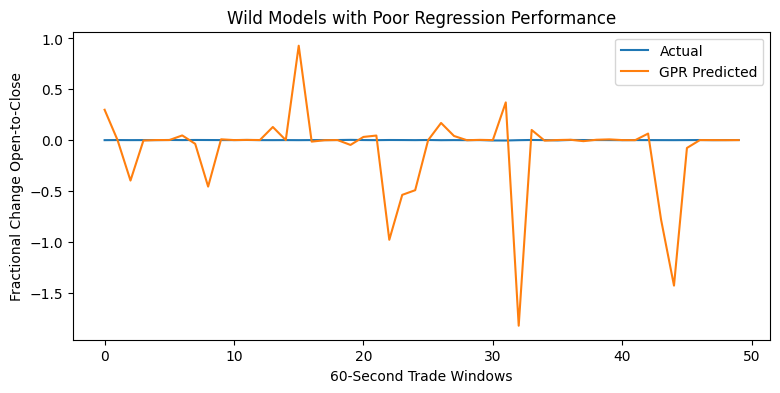

In [70]:
# plt.plot(errors_bayes,  'r', label = 'Bayesian Regression' ,linewidth = 2.)
# plt.plot([errors_linear]*X_train1.shape[0], 'b:', label = 'Linear Regression')

# plt.yscale('log')
# plt.xlabel('Iterations')
# plt.ylabel('Validation MSE')
# plt.legend()

# plt.figure()
# plt.bar(np.arange(Linear.w.size),Linear.w,align='center', alpha=0.5)
# plt.ylabel(r'$m$ (LS)')
# plt.title(r'LS estimate of $\theta$')
# plt.show

fig, ax = plt.subplots(figsize=(9, 4))
num = 60
ax.plot(y_test[10:num],label="Actual")
# ax.plot(y_pred_lin[10:num],label="Linear Predicted")
# ax.plot(y_pred_bayes[10:num],label="Bayes Predicted")
# ax.plot(y_pred_SVR[10:num],label="SVR Predicted")
# ax.plot(y_pred_DT[10:num],label="DT Predicted")
# ax.plot(y_pred_ETR[10:num],label="ETR Predicted")
# ax.plot(y_pred_dnn[10:num],label="DNN Predicted")
# ax.plot(y_pred_emp_bayes[10:num],label="Empirical Bayes Predicted")
# ax.plot(y_pred_EM[10:num],label="EM Predicted")
# ax.plot(y_pred_VB[10:num],label="VB Predicted")
ax.plot(y_pred_gpr[10:num],label="GPR Predicted")
ax.legend()
ax.set_title("Wild Models with Poor Regression Performance")
ax.set_ylabel("Fractional Change Open-to-Close")
ax.set_xlabel("60-Second Trade Windows")


# plt.figure()
# plt.bar(np.arange(Bayes.w_mean.size),Bayes.w_mean,align='center', alpha=0.5)
# plt.ylabel(r'$m_N$')
# plt.title(r'Posterior mean $m_N$ of $\theta$ (Bayes regression)')
# plt.show

# Question 2: 
- What MSE does this model achieve for the given values of $\alpha$ and $\beta$?
- What is the effect of changing $\alpha$ and $\beta$ on the MSE? Experiment with different settings of $\alpha$ and $\beta$.
- What value of $\beta$ yields the lowest MSE? Does it match standard deviation in the ground truth model?

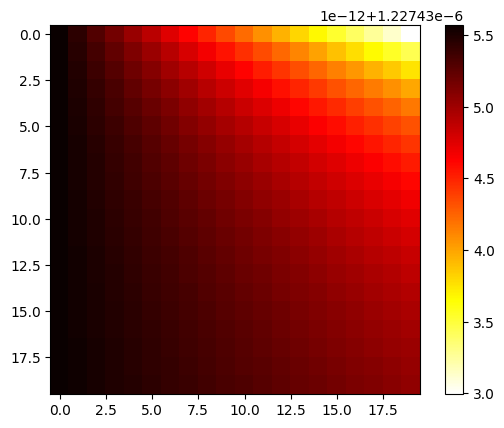

In [51]:
numa=20
numb=20
errors_bayes_ = np.zeros((numa,numb))

for index_a, alpha in enumerate(np.linspace(0.1,200,numa)):
    for index_b,beta in enumerate(np.linspace(4,20,numb)):
        Bayes = BayesianRegression(alpha=alpha, beta=beta)      
        Bayes.fit(X_train1, y_train)
        errors_bayes_[index_a,index_b] =  mean_squared_error(Bayes.predict(X_test1),y_test)

plt.imshow(errors_bayes_.T, cmap='hot_r')
plt.colorbar()
plt.show()

# Question 3: 
- Plot the parameters $\alpha$ and $\beta$ for each iteration of the empirical Bayes algorithm. 
- What are the values of $\alpha$ and $\beta$ at convergence? Try to interpret those value; does the prior have much weightage?  Compare also those values to the values you experimented with in Question 2.

# Question 4: 
- Plot the parameters $\alpha$ and $\beta$ for each iteration of the EM algorithm. 
- What are the values of $\alpha$ and $\beta$ at convergence? Try to interpret those value; does the prior have much weightage?  Compare also those values to the values you obtained in Question 3 for the empirical Bayes approach.

# Question 5: 
- Plot the parameters $\alpha$ and $\beta$ for each iteration of the VB algorithm. Since $\alpha$ is now a vector, you can perhaps plot the median or mean of $\alpha$, instead of the individual components.
- What are the values of $\alpha$ and $\beta$ at convergence? Create a bar plot of the $\alpha$ values at convergence. Try to interpret those value; does the prior have much weightage? Are some $\alpha$ values large, and if so, what does that mean? Compare also those values to the values you obtained in Question 3 and 4 for the empirical Bayes and EM approach respectively.

## Model Selection
We can conduct model selection with the empirical Bayesian approach. Given a number of features $n$, we select the most $n$ significant features (according to the correlation matrix). We then fit the empirical Bayesian model and compute its evidence. We can then select the best model according to the evidence.

In [52]:
index_sort = (sorted(list(range(13)), key = lambda i: corr_mtx['MEDV'].abs()[i], reverse = True))
evidences = []

models = []
indexes = np.arange(1,14)
print(X_train1.shape)

for num_feature in range(14):
    slice_index = index_sort[:num_feature+1]
    tmp_X = feature.transform(X_train[:,slice_index])
    model = EmpiricalBayesRegression()
    model.fit(tmp_X, y_train)
    evidences.append(model.log_evidence(tmp_X, y_train))
    models.append(model)


plt.plot(evidences)
plt.title("Model evidence")
plt.xlabel("Numbers of features")
plt.ylabel("log evidence")
plt.show()
print(evidences)

NameError: name 'corr_mtx' is not defined

In [ ]:
slice_index = index_sort[:11]
print(index_sort)
X_train_modified, X_test_modified = feature.transform(X_train[:,slice_index]), feature.transform(X_test[:,slice_index])
print(X_train_modified.shape, X_test_modified.shape)

Linear = LinearRegression()
Linear.fit(X_train_modified, y_train)
errors_linear = mean_squared_error(Linear.predict(X_test_modified),y_test)

Bayes = BayesianRegression(alpha=1., beta=100.)
errors_bayes = []

empirical_Bayes = EmpiricalBayesRegression()
empirical_Bayes.fit(X_train_modified, y_train)
errors_embayes = mean_squared_error(empirical_Bayes.predict(X_test_modified),y_test)

for idx in range(X_train.shape[0]):
    Bayes.fit(X_train_modified[idx:idx+1], y_train[idx:idx+1])
    errors_bayes.append(mean_squared_error(Bayes.predict(X_test_modified),y_test))
    
    
plt.plot(errors_bayes,  'r', label = 'Bayesian Regression' ,linewidth = 2.)
plt.plot([errors_linear]*X_train.shape[0], 'b:', label = 'Linear Regression')
plt.plot([errors_embayes]*X_train.shape[0], 'y-.', label = 'Empirical Regression')

plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Validation MSE')
plt.legend()
print(errors_bayes[-1],errors_linear,errors_embayes)




# Question 6: 
- Does model selection in the empirical Bayes method help to reduce the prediction error? 
- Try to interpret the feature set corresponding to the lowest prediction error. 

## Other implementations [optional]
There are implementations for the LS and empirical Bayes methods in the scikit-learn Python library. The implementation in scikit-learn of the empirical Bayes method adopts different optimization methods and might be more robust than the implementations provided above.

Note that there is another difference between the implementations above and the Scikit-implementations. The Scikit class does not require the constant column in the input, while the implementations above requires the constant column added, before it is fed into the fit method.

In [ ]:
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
Linear_sk = LinearRegression()
Linear_sk.fit(X_train_modified[:,1:], y_train)
errors_linear_sk = mean_squared_error(Linear_sk.predict(X_test_modified[:,1:]),y_test)
empirical_Bayes_sk = BayesianRidge()
empirical_Bayes_sk.fit(X_train_modified[:,1:], y_train)
errors_empirical_sk = mean_squared_error(empirical_Bayes_sk.predict(X_test_modified[:,1:]),y_test)
print('Linear Regression MSE:',errors_linear,' sklearn Linear Regression MSE:', errors_linear_sk)
print('empirical Bayes MSE:',errors_embayes,' sklearn empirical Bayes MSE:', errors_empirical_sk)